# **Importing Required Libraries**

In [1]:
from google.colab import drive
import zipfile
import os
import shutil
import random
import matplotlib.pyplot as plt
import seaborn as sns  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50  
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# **Loading and Extracting Dataset**


In [2]:
drive.mount('/content/drive')

root_dir = '/content/drive/MyDrive'
dataset_zip = os.path.join(root_dir, 'cats_vs_dogs_small_dataset.zip')
extracted_dataset_dir = os.path.join(root_dir, 'cats_vs_dogs_small_dataset')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
'''
with zipfile.ZipFile(dataset_zip, 'r') as zip_file:
    zip_file.extractall(extracted_dataset_dir)
'''

"\nwith zipfile.ZipFile(dataset_zip, 'r') as zip_file:\n    zip_file.extractall(extracted_dataset_dir)\n"

In [4]:
cats_dir = os.path.join(extracted_dataset_dir, 'cats_vs_dogs_small_dataset/cat')
dogs_dir = os.path.join(extracted_dataset_dir, 'cats_vs_dogs_small_dataset/dog')

# **Splitting Dataset**


In [5]:
def organize_data_folders(base_dir, cats_images, dogs_images, num_train, num_val, num_test):
    train_directory = os.path.join(base_dir, 'train_set')
    validation_directory = os.path.join(base_dir, 'validation_set')
    test_directory = os.path.join(base_dir, 'test_set')

    for dir in [train_directory, validation_directory, test_directory]:
        shutil.rmtree(dir, ignore_errors=True)
        os.makedirs(os.path.join(dir, 'cat'), exist_ok=True)
        os.makedirs(os.path.join(dir, 'dog'), exist_ok=True)

    random.shuffle(cats_images)
    random.shuffle(dogs_images)

    def copy_image_files(src_folder, dest_folder, img_files):
        for file in img_files:
            shutil.copy(os.path.join(src_folder, file), os.path.join(dest_folder, file))

    copy_image_files(cats_dir, os.path.join(train_directory, 'cat'), cats_images[:num_train // 2])
    copy_image_files(dogs_dir, os.path.join(train_directory, 'dog'), dogs_images[:num_train // 2])

    copy_image_files(cats_dir, os.path.join(validation_directory, 'cat'), cats_images[num_train // 2:num_train // 2 + num_val // 2])
    copy_image_files(dogs_dir, os.path.join(validation_directory, 'dog'), dogs_images[num_train // 2:num_train // 2 + num_val // 2])

    copy_image_files(cats_dir, os.path.join(test_directory, 'cat'), cats_images[num_train // 2 + num_val // 2:num_train // 2 + num_val // 2 + num_test // 2])
    copy_image_files(dogs_dir, os.path.join(test_directory, 'dog'), dogs_images[num_train // 2 + num_val // 2:num_train // 2 + num_val // 2 + num_test // 2])

    return train_directory, validation_directory, test_directory


# **Data Generators with Different Augmentations**


In [6]:
def setup_data_generators(train_dir, val_dir, test_dir, img_size, batch_sz):
    train_data_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )

    validation_data_gen = ImageDataGenerator(rescale=1./255)
    test_data_gen = ImageDataGenerator(rescale=1./255)

    train_gen = train_data_gen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_sz,
        class_mode='binary'
    )
    val_gen = validation_data_gen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_sz,
        class_mode='binary'
    )
    test_gen = test_data_gen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_sz,
        class_mode='binary'
    )
    return train_gen, val_gen, test_gen

# **Model Architecture for Scratch Model**


In [7]:
def build_custom_scratch_model(img_size):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# **Improved Pretrained Model Using ResNet50**


In [8]:
def build_resnet_model(img_size):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# **Model Training and Evaluation**


In [9]:
def train_model_and_plot(model, train_gen, val_gen, num_epochs):
    history = model.fit(train_gen, epochs=num_epochs, validation_data=val_gen)
    return history

In [10]:
def plot_enhanced_metrics(history, title_prefix):
    plt.figure(figsize=(12, 6))

    sns.set(style="whitegrid")
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
    plt.title(f'{title_prefix} - Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='purple')
    plt.title(f'{title_prefix} - Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# **Comparing Different Models**


In [11]:
def compare_model_performance(sample_counts, results_dict):
    for sample_count in sample_counts:
        train_acc_scratch = results_dict[sample_count]['scratch']['history'].history['accuracy']
        val_acc_scratch = results_dict[sample_count]['scratch']['history'].history['val_accuracy']
        train_acc_resnet = results_dict[sample_count]['resnet']['history'].history['accuracy']
        val_acc_resnet = results_dict[sample_count]['resnet']['history'].history['val_accuracy']

        # Comparison plots
        plt.figure(figsize=(10, 5))
        plt.plot(train_acc_scratch, label='Scratch Model - Training Accuracy', color='skyblue')
        plt.plot(val_acc_scratch, label='Scratch Model - Validation Accuracy', color='dodgerblue')
        plt.plot(train_acc_resnet, label='ResNet Model - Training Accuracy', color='orange')
        plt.plot(val_acc_resnet, label='ResNet Model - Validation Accuracy', color='darkorange')
        plt.title(f'Accuracy Comparison for {sample_count} Samples')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

# **Finalizing Parameters and Running Models**


In [12]:
image_dimensions = (224, 224)
batch_size_value = 32
validation_data_count = 600
testing_data_count = 600
cat_image_files = os.listdir(cats_dir)
dog_image_files = os.listdir(dogs_dir)

sample_set_sizes = [1000, 1500, 2000, 2500]
evaluation_results = {}

# **Running models for different sample sizes**


Found 1000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 972ms/step - accuracy: 0.5395 - loss: 28.0936 - val_accuracy: 0.5000 - val_loss: 19.5655
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 54s 509ms/step - accuracy: 0.5768 - loss: 17.3044 - val_accuracy: 0.5100 - val_loss: 12.8325
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 515ms/step - accuracy: 0.6167 - loss: 14.8028 - val_accuracy: 0.5200 - val_loss: 10.0886
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 501ms/step - accuracy: 0.5962 - loss: 11.5466 - val_accuracy: 0.5050 - val_loss: 9.5143
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 535ms/step - accuracy: 0.6025 - loss: 9.7075 - val_accuracy: 0.5183 - val_loss: 7.6612
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 570ms/step - accuracy: 0.5877 - loss: 7.5025 - val_accuracy: 0.5017 - val_loss: 8.0466
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 504ms/step - accuracy: 0.5680 - loss: 6.5496 - val_accuracy: 0.5067 - val_loss: 6.0529
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 506ms/step - accuracy: 0.6454 - loss: 5.6995 - val_accuracy

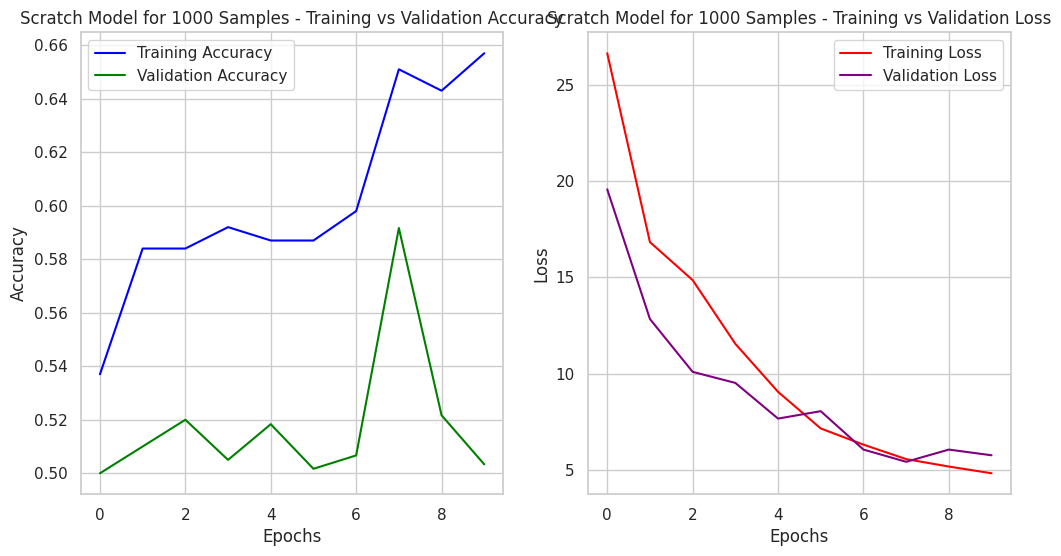

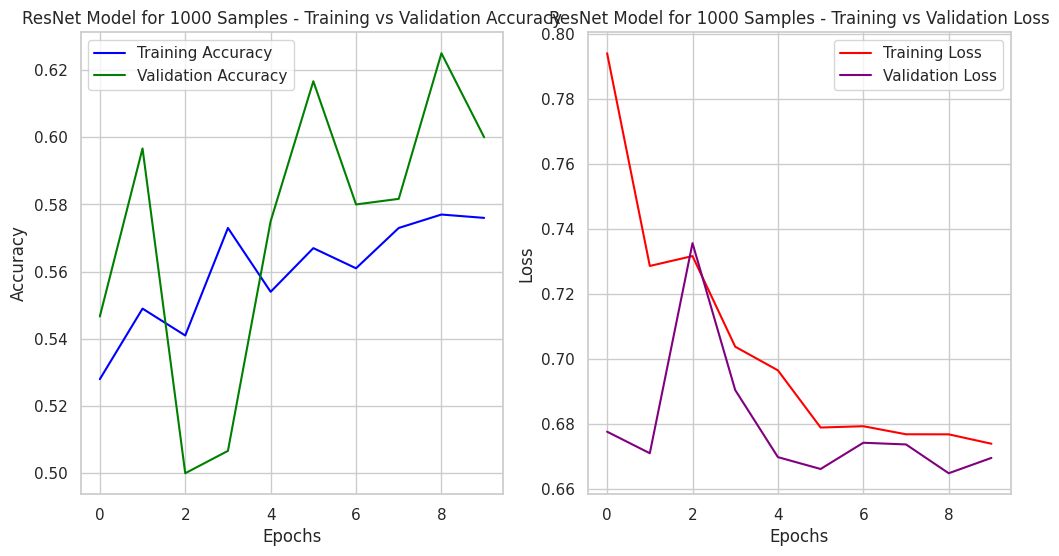

Found 1500 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 56s 970ms/step - accuracy: 0.5753 - loss: 26.4160 - val_accuracy: 0.4967 - val_loss: 13.3991
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 559ms/step - accuracy: 0.5539 - loss: 22.6608 - val_accuracy: 0.4850 - val_loss: 22.4943
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 43s 600ms/step - accuracy: 0.5571 - loss: 12.6092 - val_accuracy: 0.5267 - val_loss: 8.0545
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 543ms/step - accuracy: 0.6050 - loss: 8.2591 - val_accuracy: 0.5567 - val_loss: 6.5619
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 543ms/step - accuracy: 0.6291 - loss: 6.2067 - val_accuracy: 0.5817 - val_loss: 6.2965
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 543ms/step - accuracy: 0.6212 - loss: 5.4030 - val_accuracy: 0.5700 - val_loss: 5.5369
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 40s 532ms/step - accuracy: 0.6058 - loss: 4.8477 - val_accu

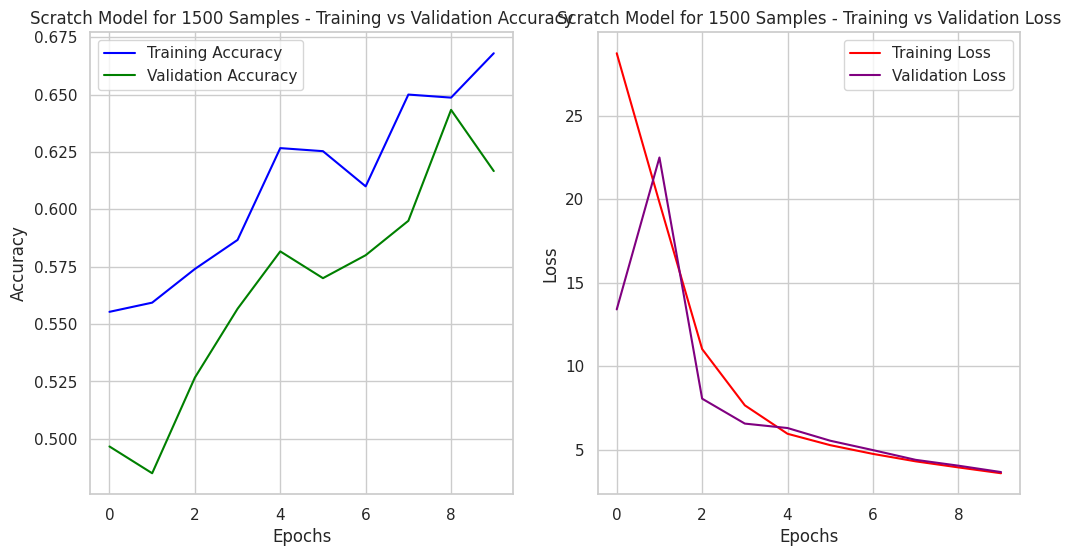

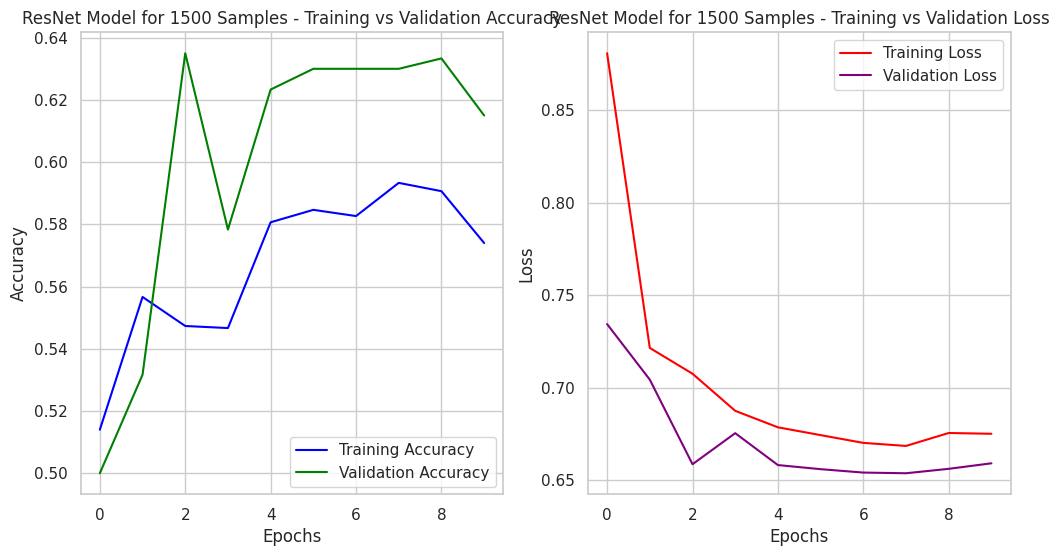

Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 788ms/step - accuracy: 0.5456 - loss: 25.4603 - val_accuracy: 0.5200 - val_loss: 9.9494
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 552ms/step - accuracy: 0.5783 - loss: 14.1120 - val_accuracy: 0.5350 - val_loss: 7.3758
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 554ms/step - accuracy: 0.5745 - loss: 7.2842 - val_accuracy: 0.5000 - val_loss: 10.5914
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 577ms/step - accuracy: 0.6090 - loss: 5.5155 - val_accuracy: 0.5000 - val_loss: 6.7836
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 530ms/step - accuracy: 0.6565 - loss: 4.8309 - val_accuracy: 0.5033 - val_loss: 5.5033
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 530ms/step - accuracy: 0.6583 - loss: 4.2643 - val_accuracy: 0.5233 - val_loss: 4.9695
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 536ms/step - accuracy: 0.6754 - loss: 3.7732 - val_accura

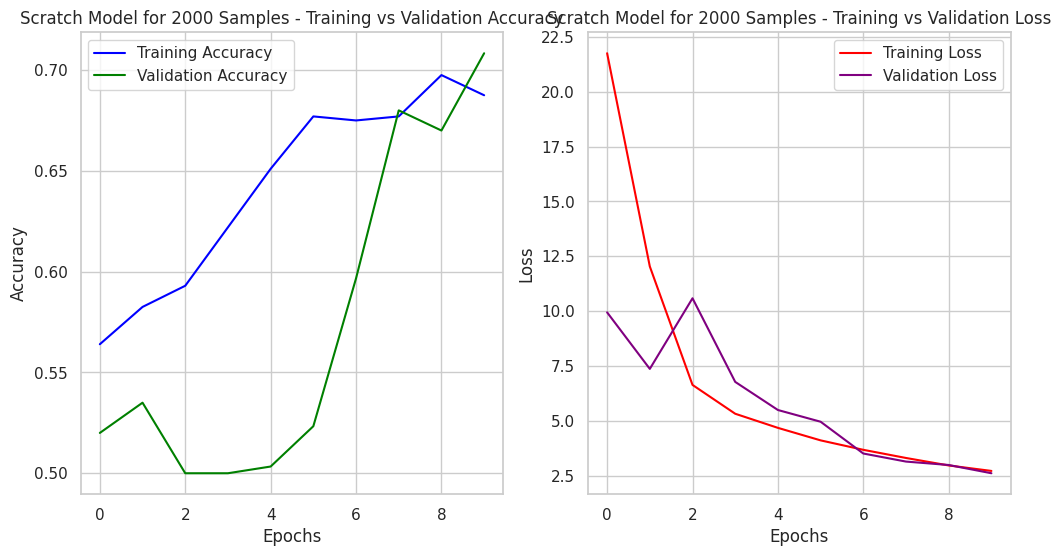

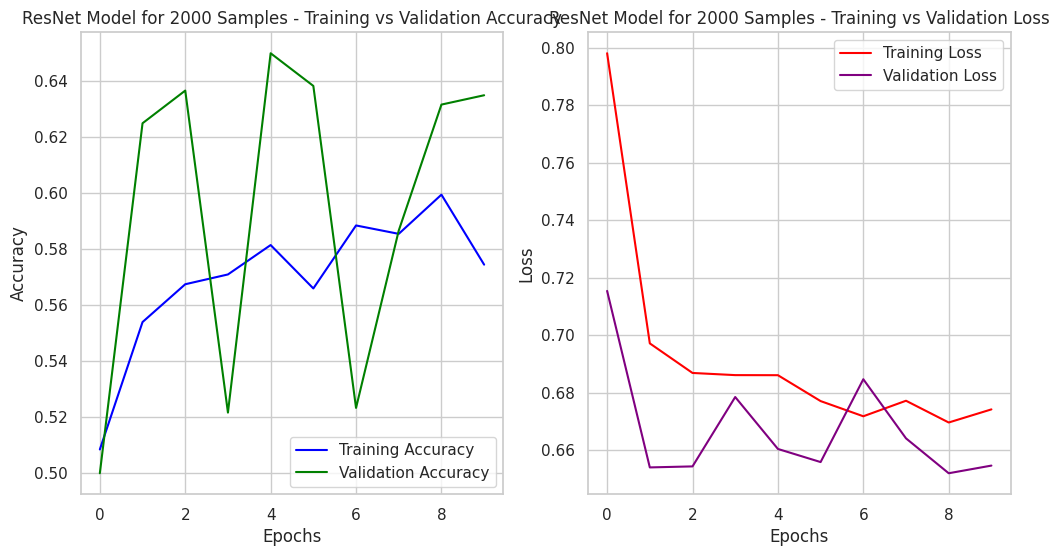

Found 2500 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 62s 645ms/step - accuracy: 0.5327 - loss: 26.4176 - val_accuracy: 0.5000 - val_loss: 11.2321
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 70s 549ms/step - accuracy: 0.5904 - loss: 14.9811 - val_accuracy: 0.5183 - val_loss: 8.7546
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 82s 558ms/step - accuracy: 0.6055 - loss: 8.9048 - val_accuracy: 0.5117 - val_loss: 9.7966
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 47s 547ms/step - accuracy: 0.6384 - loss: 5.9957 - val_accuracy: 0.5467 - val_loss: 5.8790
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 46s 543ms/step - accuracy: 0.6322 - loss: 5.0639 - val_accuracy: 0.5683 - val_loss: 4.9655
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 45s 536ms/step - accuracy: 0.6932 - loss: 4.3118 - val_accuracy: 0.6017 - val_loss: 4.1323
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 82s 534ms/step - accuracy: 0.6795 - loss: 3.7314 - val_accura

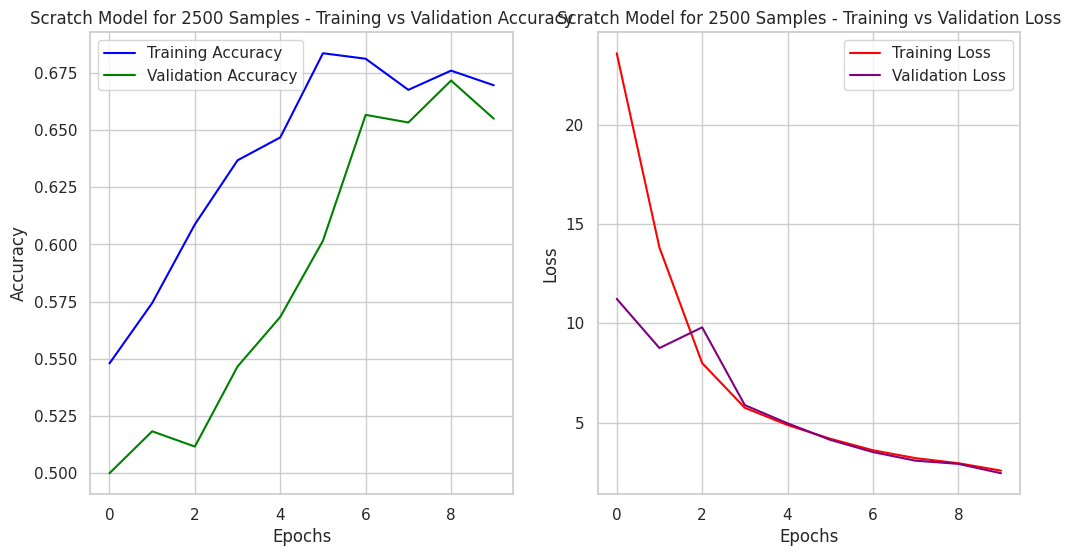

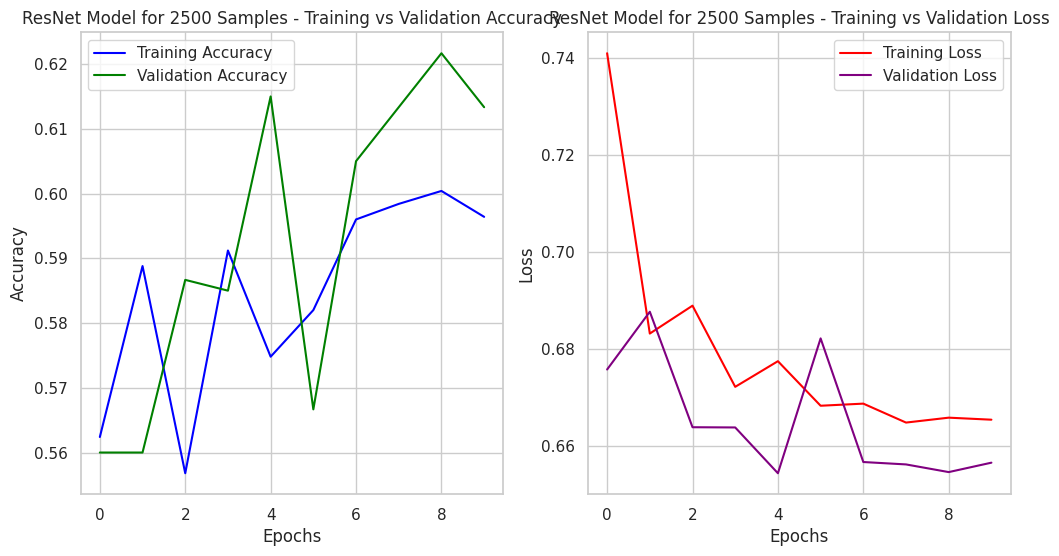

In [14]:
for sample_size in sample_set_sizes:
    train_dir, val_dir, test_dir = organize_data_folders(extracted_dataset_dir, cat_image_files, dog_image_files, sample_size, validation_data_count, testing_data_count)
    train_gen, val_gen, test_gen = setup_data_generators(train_dir, val_dir, test_dir, image_dimensions, batch_size_value)

    # Train scratch model
    custom_scratch_model = build_custom_scratch_model(image_dimensions)
    history_scratch_model = train_model_and_plot(custom_scratch_model, train_gen, val_gen, num_epochs=10)

    # Train ResNet model
    resnet_model = build_resnet_model(image_dimensions)
    history_resnet_model = train_model_and_plot(resnet_model, train_gen, val_gen, num_epochs=10)

    # Store the results
    evaluation_results[sample_size] = {
        'scratch': {'model': custom_scratch_model, 'history': history_scratch_model},
        'resnet': {'model': resnet_model, 'history': history_resnet_model}
    }

    # Plot metrics
    plot_enhanced_metrics(history_scratch_model, f'Scratch Model for {sample_size} Samples')
    plot_enhanced_metrics(history_resnet_model, f'ResNet Model for {sample_size} Samples')

# **Comparison Across Sample Sizes**


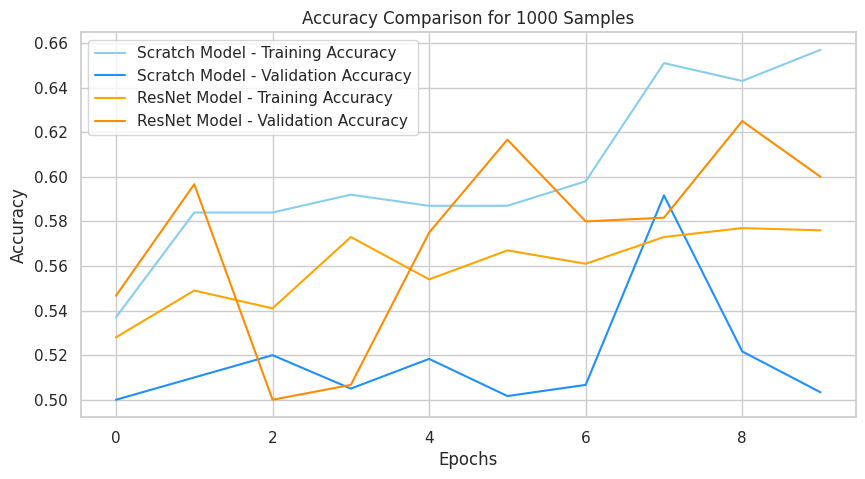

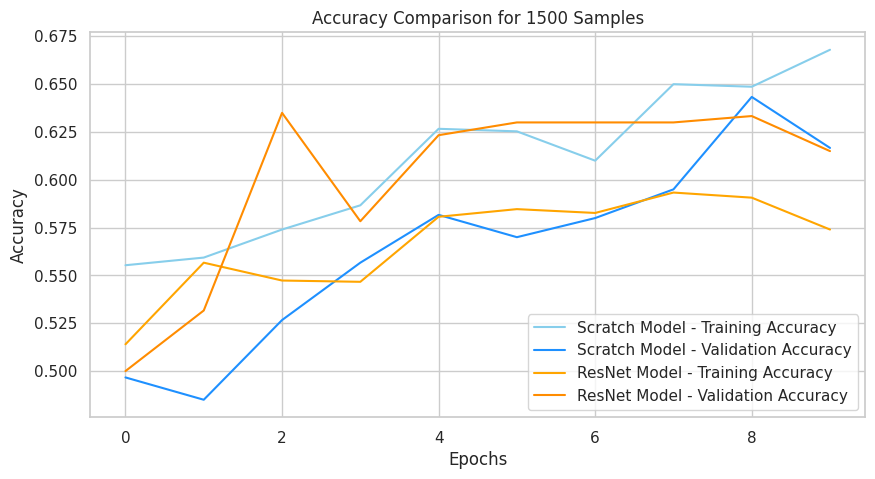

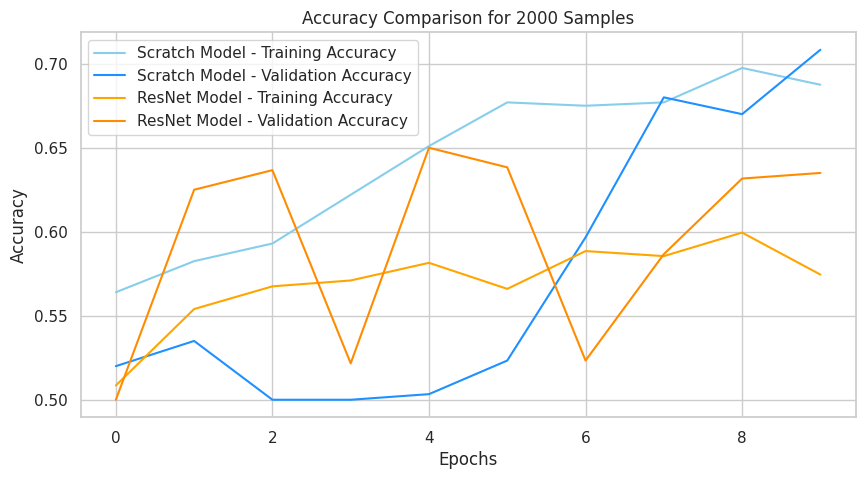

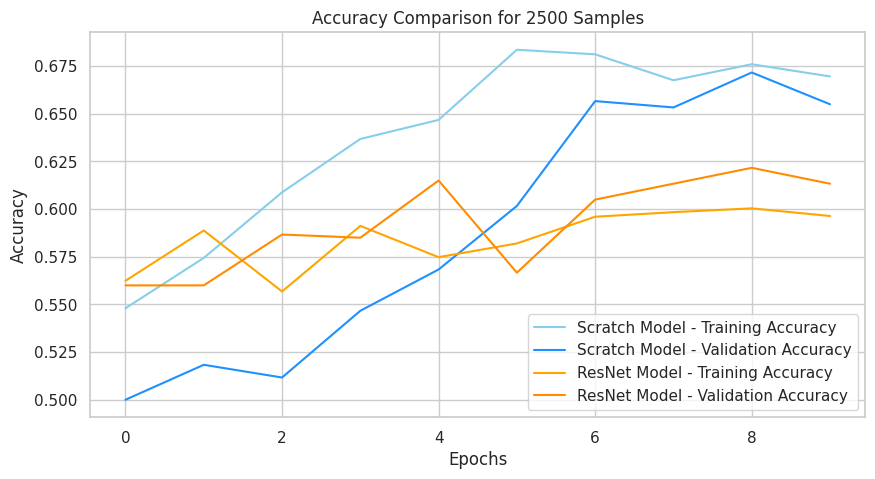

In [15]:
compare_model_performance(sample_set_sizes, evaluation_results)